# Week 3
## Data retrieval, preprocessing, and normalization for ML


## Basic Outline
  
* Where do data come from? Data retreival.
* Ideal datasets and data types
* Common wrangling needs and implementations

## Where did you get your data?



* Generated in-house (stored as CSVs, TSVs, SQL, proprietary, etc)

* Collaborators

* Public sources

## Scripting data retrieval improves reproducibility

In [1]:
# you may need to:
# !pip install requests

In [2]:
# Downloading a data file from a remote repository
import urllib

URL = "https://dcc.icgc.org/api/v1/download?fn=/release_18/Projects/BRCA-US/protein_expression.BRCA-US.tsv.gz"
FILENAME = "brca_protein_expression.tsv.gz"

urllib.request.urlretrieve(URL, FILENAME)

('brca_protein_expression.tsv.gz', <http.client.HTTPMessage at 0x1048925c0>)

* Scraping tools such as Mechanize and BeautifulSoup allow extraction of data from websites


In [3]:
import requests
# Retrieving data from a remote web service in JSON format that gets converted to a python structure:
def get_genome_sequence_ensembl(chromosome, start, end):
    """ API described here http://rest.ensembl.org/documentation/info/sequence_region"""
    url = 'https://rest.ensembl.org/sequence/region/human/{0}:{1}..{2}:1?content-type=application/json'.format(
        chromosome, start, end)
    r = requests.get(url, headers={"Content-Type": "application/json"}, timeout=10.000)
    if r.ok:
        return r.json()['seq']
print(get_genome_sequence_ensembl(7, 200000,200100))

TTCTTGACACTGATTGATCTGCCAAAAGGGGAAGAATGAGTCCAGCTAGAATCCAGGACTAACCAGCGGGTGAGCTTCAAGGAACAAAGGGCTTCCGCTGG



## Pandas covers most of the data retrieval needs

In [5]:
import pandas as pd

# Let's read with pandas
# Note that we do not even need to unzip the file before opening!
brca_data = pd.read_csv(FILENAME, sep="\t")
brca_data.head(1)

,icgc_donor_id,project_code,icgc_specimen_id,icgc_sample_id,submitted_sample_id,analysis_id,antibody_id,gene_name,gene_stable_id,gene_build_version,normalized_expression_level,verification_status,verification_platform,platform,experimental_protocol,raw_data_repository,raw_data_accession
0,DO4143,BRCA-US,SP8807,SA11426,TCGA-A1-A0SK-01A-21-A13A-20,10694,PAI-1,SERPINE1,NaN,NaN,1.769954,not tested,NaN,M.D. Anderson Reverse Phase Protein Array Core,MDA_RPPA_Core http://tcga-data.nci.nih.gov/tcg...,TCGA,TCGA-A1-A0SK-01A-21-A13A-20


## Pandas can even retrieve from an SQL database directly

In [8]:
# you may need to 
!pip install sqlalchemy
!pip install pymysql

     |████████████████████████████████| 47 kB 2.9 MB/s eta 0:00:011


In [10]:
!which conda

/Users/Alec/anaconda3/bin/conda


In [11]:
import sqlalchemy as sa
# Connect to UCSC genomic database
engine = sa.create_engine(
    'mysql+pymysql://genome@genome-mysql.cse.ucsc.edu/hg38', 
    poolclass=sa.pool.NullPool
)
# select 3 SNPs from Chromosome Y
sql_df = pd.read_sql(
    """
    SELECT * 
    FROM snp147Common 
    WHERE chrom='chrY' 
    LIMIT 3
    """, 
    engine
)

In [12]:
sql_df.shape[1]

26


## Pandas dataframes

* Dataframes are convenient containers for mixed data types

* Pandas is *incredibly useful* for data wrangling

* sklearn is happy to accept Pandas dataframes as input

* Pandas is built for exploratory analysis, visualization and stat tests / ML 

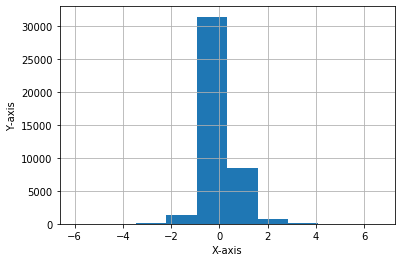

In [16]:
# Plotting boilerplate
import matplotlib.pyplot as plt

brca_data['normalized_expression_level'].hist();
plt.xlabel('X-axis')
plt.ylabel('Y-axis');

## Pre-processing a dataset: when are ready for ML?

* Ideally, data are organized as a table: examples-vs-features

* Data from multiple sources are combined

* Missing data are handled

* Features have been combined and manipulated as needed

* Any data that need to be normalized have been normalized

* Data are of the correct type (e.g. categorical vs continuous, boolean vs int)

## Let's have a look at Boston housing prices

In [19]:
boston = pd.read_csv('boston_data.csv', sep=",")
boston.head()

,Id,LotFrontage,CentralAir,1stFlrSF,SaleCondition,SalePrice
0,1,65.0,Y,856,Normal,208500
1,2,80.0,Y,1262,Normal,181500
2,3,68.0,Y,920,Normal,223500
3,4,60.0,Y,961,Abnorml,140000
4,5,84.0,Y,1145,Normal,250000


In [21]:
boston['LotFrontage'][boston['LotFrontage'].isna()].fillna(0)

7     0.0
12    0.0
14    0.0
16    0.0
24    0.0
31    0.0
42    0.0
Name: LotFrontage, dtype: float64

## Pre-processing a dataset: when are ready for ML?
* ~~Ideally, data are organized as a table: examples-vs-features~~
* Data from multiple sources are combined
* Missing data are handled
* Features have been combined and manipulated as needed
* Any data that need to be normalized have been normalized
* Data are of correct type (e.g. categorical vs continuous, boolean vs int)

## Combining data from multiple sources

In [22]:
boston_second_floor = pd.read_csv(
    'boston_second_floor.csv', 
    sep=",")
boston_second_floor.head()
#boston.head()

,Id,2ndFlrSF
0,2,0
1,1,854
2,3,866
3,4,756
4,5,1053


## Combining data from multiple sources

In [23]:
# Let's combine boston and boston second floor
boston = pd.merge(boston, boston_second_floor, on="Id")
boston.head()

,Id,LotFrontage,CentralAir,1stFlrSF,SaleCondition,SalePrice,2ndFlrSF
0,1,65.0,Y,856,Normal,208500,854
1,2,80.0,Y,1262,Normal,181500,0
2,3,68.0,Y,920,Normal,223500,866
3,4,60.0,Y,961,Abnorml,140000,756
4,5,84.0,Y,1145,Normal,250000,1053


In [24]:
# Let's add some additional data
boston3 = pd.read_csv("boston_additional.csv", sep=",")
boston3.head()

/Users/Alec/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,Id,CentralAir,1stFlrSF,SaleCondition,SalePrice,LotFrontage
0,44,Y,938,Normal,130250,NaN
1,45,Y,1150,Normal,141000,70.0
2,46,Y,1752,Normal,319900,61.0


## Thus far

In [25]:
boston.tail(10)
#boston.shape
#boston.tail()

,Id,LotFrontage,CentralAir,1stFlrSF,SaleCondition,SalePrice,2ndFlrSF
33,34,70.0,Y,1700,Normal,165500,0
34,35,60.0,Y,1561,Normal,277500,0
35,36,108.0,Y,1132,Normal,309000,1320
36,37,112.0,Y,1097,Normal,145000,0
37,38,74.0,Y,1297,Normal,153000,0
38,39,68.0,Y,1057,Abnorml,109000,0
39,40,65.0,N,1152,AdjLand,82000,0
40,41,84.0,Y,1324,Abnorml,160000,0
41,42,115.0,Y,1328,Normal,170000,0
42,43,NaN,Y,884,Normal,144000,0


## Pre-processing a dataset: when are ready for ML?
* ~~Ideally, data are organized as a table: examples-vs-features~~
* ~~Data from multiple sources are combined~~
* Missing data are handled
* Features have been combined and manipulated as needed
* Any data that need to be normalized have been normalized
* Data are of correct type (e.g. categorical vs continuous, boolean vs int)

## Missing data
There are a number of ways to handle missing data:

* Drop all records with a value missing (simplest, but can lead to bias)
* Substitute all missing values with an approximated value (usually depends on data and algorithm)
* Add additional feature indicating when a value is missing

## Missing data

In [26]:
# Drop all records with missing data
#boston.isnull().tail()
# boston.isnull().sum()
# boston.isnull().sum().sum()
#boston.tail()
#boston.dropna().tail()
boston.dropna().isnull().sum()

Id               0
LotFrontage      0
CentralAir       0
1stFlrSF         0
SaleCondition    0
SalePrice        0
2ndFlrSF         0
dtype: int64

In [27]:
# Substitute missing values
# boston.fillna("Value!").tail()
boston.fillna({"2ndFlrSF": "Value1!", "LotFrontage": "Value2!"}).tail()

,Id,LotFrontage,CentralAir,1stFlrSF,SaleCondition,SalePrice,2ndFlrSF
38,39,68,Y,1057,Abnorml,109000,0
39,40,65,N,1152,AdjLand,82000,0
40,41,84,Y,1324,Abnorml,160000,0
41,42,115,Y,1328,Normal,170000,0
42,43,Value2!,Y,884,Normal,144000,0


In [25]:
# Substitute missing values with mean
# print(boston.mean())
#boston.fillna(boston.mean()).tail()
#boston.fillna(boston.median()).tail()

In [26]:
# Add column indicating missing values
# boston["2ndFlrSF"].isnull()
#boston["missing_second_floor"] = boston["2ndFlrSF"].isnull()
# boston.tail()
# boston = boston.fillna(boston.mean())
# boston.tail()

In [27]:
# You may need to upgrade Scikit-learn (and restart Jupyter kernel afterwards) to use Imputer
# !pip install scikit-learn --upgrade

In [46]:
# Imputation is a general technique for "guessing" appropriate missing values
# It could be implemented as a complex ML regression algorithm or a simple 'take an average' strategy.
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()

estimators: KNNClassifier, KNNRegressor, Kmeans clustering
    - fit, predict, score
transformers: SimpleImputer, KNNImputer, OneHotEncoder
    - fit, transform, fit_transform

In [35]:
series = boston['LotFrontage'].head()
dataframe = boston[['LotFrontage']].head()

In [39]:
dataframe.shape

(5, 1)

In [40]:
import numpy as np

In [41]:
np.array(series)

array([65., 80., 68., 60., 84.])

In [44]:
type(series.values)

numpy.ndarray

In [49]:
dataframe.values

array([[65.],
       [80.],
       [68.],
       [60.],
       [84.]])

In [38]:
series.shape

(5,)

In [32]:
import sklearn

In [48]:
imputer.fit_transform(boston[["LotFrontage"]])

array([[ 65.],
       [ 80.],
       [ 68.],
       [ 60.],
       [ 84.],
       [ 85.],
       [ 75.],
       [ 60.],
       [ 51.],
       [ 50.],
       [ 70.],
       [ 85.],
       [ 60.],
       [ 91.],
       [ 60.],
       [ 51.],
       [ 60.],
       [ 72.],
       [ 66.],
       [ 70.],
       [101.],
       [ 57.],
       [ 75.],
       [ 44.],
       [ 60.],
       [110.],
       [ 60.],
       [ 98.],
       [ 47.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 85.],
       [ 70.],
       [ 60.],
       [108.],
       [112.],
       [ 74.],
       [ 68.],
       [ 65.],
       [ 84.],
       [115.],
       [ 60.]])

1. import ('from sklearn.imputer import SimpleImputer')
2. instantiate ('imputer = SimpleImputer()')
3. fit 
4. transform/predict

In [47]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit_transform(boston[["LotFrontage"]])

array([[ 65.],
       [ 80.],
       [ 68.],
       [ 60.],
       [ 84.],
       [ 85.],
       [ 75.],
       [ 60.],
       [ 51.],
       [ 50.],
       [ 70.],
       [ 85.],
       [ 60.],
       [ 91.],
       [ 60.],
       [ 51.],
       [ 60.],
       [ 72.],
       [ 66.],
       [ 70.],
       [101.],
       [ 57.],
       [ 75.],
       [ 44.],
       [ 60.],
       [110.],
       [ 60.],
       [ 98.],
       [ 47.],
       [ 60.],
       [ 50.],
       [ 60.],
       [ 85.],
       [ 70.],
       [ 60.],
       [108.],
       [112.],
       [ 74.],
       [ 68.],
       [ 65.],
       [ 84.],
       [115.],
       [ 60.]])

## How to decide how to treat missing data?
* Very data-dependent!
* Decisions need to be justified and documented
* Implement missing data preprocessing in a reproducible way (python script)
* Don't create data from nothing
* Iris example

## Pre-processing a dataset: when are ready for ML?
* ~~Ideally, data are organized as a table: examples-vs-features~~
* ~~Data from multiple sources are combined~~
* ~~Missing data are handled~~
* Features have been combined and manipulated as needed
* Any data that need to be normalized have been normalized
* Data are of correct type (e.g. categorical vs continuous, boolean vs int)

In [52]:
# boston.head()
boston["total_sf"] = boston["1stFlrSF"] + boston["2ndFlrSF"]
boston.head()

,Id,LotFrontage,CentralAir,1stFlrSF,SaleCondition,SalePrice,2ndFlrSF,total_sf
0,1,65.0,Y,856,Normal,208500,854,1710
1,2,80.0,Y,1262,Normal,181500,0,1262
2,3,68.0,Y,920,Normal,223500,866,1786
3,4,60.0,Y,961,Abnorml,140000,756,1717
4,5,84.0,Y,1145,Normal,250000,1053,2198


In [53]:
boston['SaleCondition'].value_counts()

Normal     34
Abnorml     5
Partial     3
AdjLand     1
Name: SaleCondition, dtype: int64

In [54]:
boston.head()
boston = boston.replace({"Abnorml": "abnormal", "Normal": "normal"})
boston.head()

,Id,LotFrontage,CentralAir,1stFlrSF,SaleCondition,SalePrice,2ndFlrSF,total_sf
0,1,65.0,Y,856,normal,208500,854,1710
1,2,80.0,Y,1262,normal,181500,0,1262
2,3,68.0,Y,920,normal,223500,866,1786
3,4,60.0,Y,961,abnormal,140000,756,1717
4,5,84.0,Y,1145,normal,250000,1053,2198


## Pre-processing a dataset: when are ready for ML?
* ~~Ideally, data are organized as a table: examples-vs-features~~
* ~~Data from multiple sources are combined~~
* ~~Missing data are handled~~
* ~~Features have been combined and manipulated as needed~~
* Any data that need to be normalized have been normalized
* Data are of correct type (e.g. categorical vs continuous, boolean vs int)

## Normalization
* What is it?
* Why do it? (data sources, feature distributions)
* Types?

### Normalization

Many machine learning algorithms expect features to have similar distributions and scales.

A classic example is gradient descent, if features are on different scales some weights will update faster than others because the feature values scale the weight updates.

There are two common approaches to normalization:

* Z-score standardization
* Min-max scaling

#### Z-score standardization

Z-score standardization rescales values so that they have a mean of zero and a standard deviation of 1. Specifically we perform the following transformation:

$$z = \frac{x - \mu}{\sigma}$$

#### Min-max scaling

An alternative is min-max scaling that transforms data into the range of 0 to 1. Specifically:

$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Min-max scaling is less commonly used but can be useful for image data and in some neural networks.

In [55]:
# a = (boston['1stFlrSF'] - boston['1stFlrSF'].mean()) / boston['1stFlrSF'].std()
# boston['1stFlrSF'].hist()
# boston.head()
## boston.total_sf.hist()
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler

In [56]:
scaler = StandardScaler()

In [57]:
print(scaler.fit_transform(boston[['1stFlrSF']]))

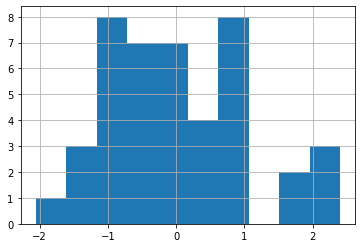

In [58]:
scaled_size = pd.Series(scale(boston.total_sf))
scaled_size.hist();

In [59]:
np.isclose(scaled_size.mean(),0)

True

In [57]:
scaled_size.mean()

In [57]:
scaled_size.std(ddof=0)
boston["normalized_total_sf"] = scaled_size

[[-1.11717197]
 [ 0.30978064]
 [-0.89223363]
 [-0.7481325 ]
 [-0.10143477]
 [-1.32805167]
 [ 1.82811445]
 [-0.23499191]
 [-0.53373814]
 [-0.34043176]
 [-0.47047424]
 [ 0.02860771]
 [-0.92035092]
 [ 1.12518213]
 [ 0.27814868]
 [-1.12420129]
 [-0.59700205]
 [ 0.42927913]
 [-0.21038928]
 [ 0.58040958]
 [-0.05574417]
 [-0.23147725]
 [ 2.18309527]
 [-0.400181  ]
 [-0.400181  ]
 [ 1.49773626]
 [-0.96252686]
 [ 1.86326106]
 [ 1.49773626]
 [-2.29809827]
 [-1.84470692]
 [ 0.19028214]
 [ 0.21137011]
 [ 1.84920242]
 [ 1.36066446]
 [-0.14712537]
 [-0.27013853]
 [ 0.43279379]
 [-0.41072499]
 [-0.07683214]
 [ 0.52768966]
 [ 0.5417483 ]
 [-1.01876145]]


In [33]:
scaler = MinMaxScaler()
print(scaler.fit_transform(boston[['1stFlrSF']]))

[[0.26352941]
 [0.58196078]
 [0.31372549]
 [0.34588235]
 [0.49019608]
 [0.21647059]
 [0.92078431]
 [0.46039216]
 [0.39372549]
 [0.43686275]
 [0.40784314]
 [0.51921569]
 [0.30745098]
 [0.76392157]
 [0.57490196]
 [0.26196078]
 [0.37960784]
 [0.60862745]
 [0.46588235]
 [0.64235294]
 [0.50039216]
 [0.46117647]
 [1.        ]
 [0.42352941]
 [0.42352941]
 [0.84705882]
 [0.29803922]
 [0.92862745]
 [0.84705882]
 [0.        ]
 [0.10117647]
 [0.55529412]
 [0.56      ]
 [0.9254902 ]
 [0.81647059]
 [0.48      ]
 [0.45254902]
 [0.60941176]
 [0.42117647]
 [0.49568627]
 [0.63058824]
 [0.63372549]
 [0.2854902 ]]


/Users/agoncear/anaconda/envs/jupyter/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Other preprocessing / normalization techniques and thoughts
* http://scikit-learn.org/stable/modules/preprocessing.html
* http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html

## Pre-processing a dataset: when are ready for ML?
* ~~Ideally, data are organized as a table: examples-vs-features~~
* ~~Data from multiple sources are combined~~
* ~~Missing data are handled~~
* ~~Features have been combined and manipulated as needed~~
* ~~Any data that need to be normalized have been normalized~~
* Data are of correct type (e.g. categorical vs continuous, boolean vs int)

In [60]:
boston['CentralAir'].unique()

array(['Y', 'N'], dtype=object)

In [34]:
#boston.head()
import numpy as np

# boston["1stFlrSF"].mean(skipna=False)
boston["CentralAir_bool"] = boston["CentralAir"] == "Y"
# boston.head()
# boston["SaleCondition"].dtype
#boston["SaleCondition"].head()
boston["SaleCondition"].astype("category").dtype
#boston["SaleCondition"] = boston["SaleCondition"].astype("category")
#boston["SaleCondition"].dtype

CategoricalDtype(categories=['AdjLand', 'Partial', 'abnormal', 'normal'], ordered=False)

In [1]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

lb = LabelBinarizer()
lb.fit_transform(['no', 'yes', 'no', 'yes'])          

array([[0],
       [1],
       [0],
       [1]])

In [67]:
lb.fit_transform(['yes', 'yes', 'no', 'no', 'maybe'])[:,1:]

array([[0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 0]])

In [3]:
!conda list

# packages in environment at /Users/Alec/anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2019.03                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
alabaster                 0.7.12                   py37_0  
anaconda                  custom                   py37_1  
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.7                    py37_0  
anaconda-project          0.8.3                      py_0  
appnope                   0.1.0                    py37_0  
appscript                 1.1.0            py37h1de35cc_0  
asn1crypto                0.24.0                   py37_0  
astroid                   2.2.5                    py37_0  
astropy                   3.2.1            py37h1de35cc_0  
atomicwrites              1.3.0                    py37_1  
attrs                     19.1.0                   py37_1  
babel                     2.7.0        

In [37]:
ohe = OneHotEncoder()
sparse_matrix = ohe.fit_transform(boston[['SaleCondition', 'CentralAir_bool']])
sparse_matrix.todense()

matrix([[0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0

### Another example of categorical data conversion to boolean features

In [38]:
x = pd.DataFrame([[0,1,2,3,4,5,6],
                  [2,np.nan,7,4,9,1,3],
                  [0.1,0.12,0.11,0.15,0.16,0.11,0.14],
                  [100,120,np.nan,127,130,121,124],
                  ['Green','Red','Blue','Blue','Green','Red','Green']], ).T
x.columns = ['A', 'B', 'C', 'D', 'E']
x

,A,B,C,D,E
0,0,2,0.1,100,Green
1,1,NaN,0.12,120,Red
2,2,7,0.11,NaN,Blue
3,3,4,0.15,127,Blue
4,4,9,0.16,130,Green
5,5,1,0.11,121,Red
6,6,3,0.14,124,Green


In [39]:
x_cat = x.copy()
for val in x['E'].unique():
    x_cat['E_{0}'.format(val)] = x_cat['E'] == val
x_cat

,A,B,C,D,E,E_Green,E_Red,E_Blue
0,0,2,0.1,100,Green,True,False,False
1,1,NaN,0.12,120,Red,False,True,False
2,2,7,0.11,NaN,Blue,False,False,True
3,3,4,0.15,127,Blue,False,False,True
4,4,9,0.16,130,Green,True,False,False
5,5,1,0.11,121,Red,False,True,False
6,6,3,0.14,124,Green,True,False,False


In [40]:
# Another option to have one feature per color is to use Pivot
# Note that it will create missing data:
x.pivot(index='A', columns='E', values='C')

E,Blue,Green,Red
A,,,
0,NaN,0.1,NaN
1,NaN,NaN,0.12
2,0.11,NaN,NaN
3,0.15,NaN,NaN
4,NaN,0.16,NaN
5,NaN,NaN,0.11
6,NaN,0.14,NaN


## Pre-processing a dataset: when are ready for ML?
* ~~Ideally, data are organized as a table: examples-vs-features~~
* ~~Data from multiple sources are combined~~
* ~~Missing data are handled~~
* ~~Features have been combined and manipulated as needed~~
* ~~Any data that need to be normalized have been normalized~~
* ~~Data are of correct type (e.g. categorical vs continuous, boolean vs int)~~

## Other types of data storage
* Image
* Text

### Image

Datasets with images also need to follow samples-by-features format.
Features in this case are pixels and their intensities. For black and white images intensities are binary. For grayscale they could be integer or floating point numbers. Color images are usually represented as multiple images - one for each color channel (e.g. red / green / blue).

Thus each image is represented as a one dimensional array, which is exactly what's needed for ML applications. To visualize it, however, we need to change its shape.

In [41]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces()     
print("Dimensionality samples x features", dataset.data.shape)

# first image - pixel intensities
dataset.data[0]

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/agoncear/scikit_learn_data
Dimensionality samples x features (400, 4096)


array([0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
       0.1570248 ], dtype=float32)

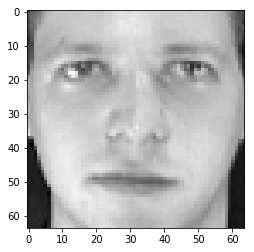

In [42]:
# reshaping to visualize
plt.imshow(dataset.data[0].reshape(64, 64), cmap=plt.cm.gray)

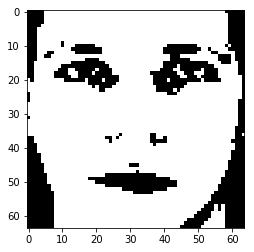

In [43]:
# Example of normalization of an image
from sklearn.preprocessing import Binarizer

image = dataset.data[0].reshape(64, 64)
normalized_image = Binarizer(threshold=0.6).fit_transform(image)
plt.imshow(normalized_image, cmap=plt.cm.gray)

### Text

Text has also to be transformed to samples-by-features format.
In the simplest case each document is a sample and ocurrence of words are its features.

In [44]:
from sklearn.datasets import fetch_20newsgroups
emails = fetch_20newsgroups(subset='train', categories=['sci.med'], shuffle=True, random_state=0)
print("Number of documents", len(emails.data))
print("Beginning of the first document", emails.data[0][:500])

Number of documents 594
Beginning of the first document From: ron.roth@rose.com (ron roth)
Subject: HYPOGLYCEMIA
X-Gated-By: Usenet <==> RoseMail Gateway (v1.70)
Organization: Rose Media Inc, Toronto, Ontario.
Lines: 31

     anello@adcs00.fnal.gov (Anthony Anello) writes:

A(>  Can anyone tell me if a bloodcount of 40 when diagnosed as hypoglycemic is
A(>  dangerous, i.e. indicates a possible pancreatic problem?  One Dr. says no, the
A(>  other (not his specialty) says the first is negligent and that another blood
A(>  test should be done.  Also, wh


In [45]:
# For every document we count word ocurrence:

from sklearn.feature_extraction.text import CountVectorizer
emails_in_ML_format = CountVectorizer().fit_transform(emails.data)
print(emails_in_ML_format.shape)

(594, 16257)


In [46]:
# Now this is how the first document looks like:
emails_in_ML_format[0].todense()

matrix([[1, 0, 0, ..., 0, 0, 0]])